In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [88]:
data = pd.read_csv('journal_mental_health.csv')
del data['Unnamed: 0'] # import bug

print(data.shape)

(804, 6)


In [32]:
data.columns

Index(['Timestamp', 'name', 'g_number', 'entry_number', 'journal', 'mood'], dtype='object')

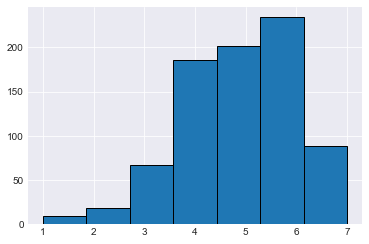

In [30]:
# 7-point scale
data.mood.hist(bins=7, edgecolor='black')

In [14]:
# Did people's moods improve?
# (Perhaps a little!)

print('Before:', data.mood.head(100).mean())
print('After: ', data.mood.tail(100).mean())

Before: 4.74
After:  5.04


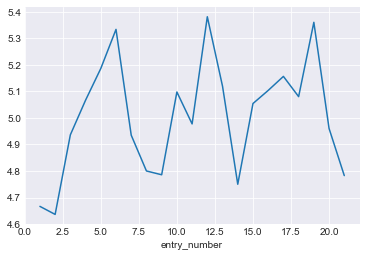

In [34]:
# It does appear to be trending upward!
data.groupby('entry_number').mood.mean().plot()

Index(['g00456349', 'g00605120', 'g00660389', 'g00871614', 'g00911674',
       'g00920707', 'g00921723', 'g00948853', 'g00970113', 'g00983492',
       'g00984263', 'g00986945', 'g01003744', 'g01006708', 'g01008246',
       'g01016610', 'g01017998', 'g01022498', 'g01032421', 'g01034027',
       'g01037770', 'g01041055', 'g01047247', 'g01048718', 'g01052247',
       'g01058915', 'g01061452', 'g01068001', 'g01070252', 'g01084119'],
      dtype='object', name='g_number')

In [51]:
# Making sure we analyze people who did the full assignment
multiple_entries = data.groupby('g_number').count()
multiple_entries = multiple_entries[multiple_entries.name > 15]

print('Highest average mood:', data[data.g_number.isin(multiple_entries.index)]\
      .groupby('g_number').mood.mean().max())
print('Lowest average mood: ', data[data.g_number.isin(multiple_entries.index)]\
      .groupby('g_number').mood.mean().min())

Highest average mood: 6.095238095238095
Lowest average mood:  3.6363636363636362


# Best predictors of mood
What did people do on their good days? What about their bad days?

In [36]:
# In a moment we'll find out which is easier to identify: good or bad moods
# We'll ignore "neutral" days (4's)

data['mood_good'] = np.where(data.mood > 4, 1, 0)
data['mood_bad'] = np.where(data.mood < 4, 1, 0)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline


def text_pipeline(x_col=data['journal'], y_trait=data['mood_good'],
                  min_df=.005, max_df=1.0, test_size=0.2, ngram=1,
                  print_accuracy=True):
    
    tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=(1,ngram))
    clf = MultinomialNB()
    pipeline = make_pipeline(tfidf, clf)
    kf = StratifiedKFold(n_splits=4)
    
    if print_accuracy == True:
        print('Using "' + x_col.name + '" to predict "' + y_trait.name + '"...')
        cvs = cross_val_score(pipeline, x_col, y_trait, cv=kf, scoring='roc_auc').mean()
        print('Accuracy: {}'.format(round(cvs, 2)))
    
    pipeline.fit(x_col, y_trait)
    return pipeline


def top_words(col='journal', y='mood_good', sort=True, df=data, min_df=.01,
              max_df=.3, ngram=1):
    x_col = df[col]
    y_trait = df[y]

    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words='english',
                              ngram_range=(1,ngram))), 
    ('classifier', MultinomialNB()),
        ])

    pipeline.fit(x_col, y_trait)
    words = {}
    
    for word, _num in pipeline.named_steps['tfidf'].vocabulary_.items():
        prob = pipeline.predict_proba([word])[0][1]
        words[word] = prob

    df_topwords = pd.DataFrame([words]).transpose()
    df_topwords.columns = ['probability']
    
    df_topwords.sort_values('probability', ascending=False, inplace=True)
    
    df_topwords['adjusted'] = df_topwords['probability']/df_topwords['probability'].mean()
    
    return df_topwords

def predict(word, col='journal', y='mood_good', df=data):
    x_col = df[col]
    y = df[y]
    
    tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df)
    clf = MultinomialNB()

    pipeline = make_pipeline(tfidf, clf)

    pipeline.fit(x_col, y)
    return pipeline.predict_proba([word])[0][1]

In [38]:
# Which one works better?

clf_good = text_pipeline()
clf_bad = text_pipeline(y_trait=data['mood_bad'])

Using "journal" to predict "mood_good"...
Accuracy: 0.63
Using "journal" to predict "mood_bad"...
Accuracy: 0.55


We can predict good moods a bit better, so let's use that from now on.

In [39]:
top_words(col='journal', y='mood_good',
          sort=True, df=data, min_df=.01, max_df=0.6, ngram=2)

,probability,adjusted
today good,0.866112,1.344386
best friend,0.847515,1.315519
love,0.843063,1.308609
catch,0.842336,1.307481
got lot,0.841567,1.306287
came home,0.836715,1.298757
relax,0.828557,1.286093
workout,0.827060,1.283770
main,0.819930,1.272702
amazing,0.817724,1.269278


# Predictors of a good day

- Being home
- Relaxing
- Best friends
- Mom / Mother's Day

# Predictors of a bad day

- Hospitals
- Feeling tired
- Managers
- Being sick
- Being too busy
- Professors
- Coworkers
- Rude people

# Just for fun: Analyzing vocabulary and personality

I can combine this with a personality test I administered and do lots of fun things. For now, let's just look at what predicts having a large vocabulary.

In [89]:
entries_all = []
threshold = 8

for person in list(data.groupby('g_number').count().index):
    entries = data[data['g_number'] == person].head(threshold)
    if len(entries) < threshold:
        name = entries['name'].iloc[0].split(', ')
        name = " ".join([name[1]] + [name[0]])
#         print(name, 'does not have enough entries')    
    else:   
        entries_list = [entries['name'].iloc[0]]
        for j in range(1, len(entries)):
            entries_list.append(entries.iloc[j]['journal'])
        if len(entries) == threshold:
            entries_all.append(entries_list)

In [90]:
vocab_all = {}

for person in entries_all:
    word_count = 0
    vocab = set()
    for entry in person[1:]:
        word_count += len(entry.split())
        for word in entry.split():
            vocab.add(word.lower())
    vocab_all[person[0]] = len(vocab)/word_count # Unique word %
    
data['vocabulary'] = data['name'].map(vocab_all)

In [91]:
personality = pd.read_csv('personality.csv')

personality['name'] = personality['Last Name, First Name']
del personality['Last Name, First Name']

In [92]:
personality['name'] = personality['name'].str.lower()\
.str.replace(' ', '').str.replace(',', ', ').str.title()

try:
    del personality['Timestamp']
except:
    pass
    
data = pd.merge(data, personality, on='name', how='left')

In [93]:
data = data.drop_duplicates(subset='journal')
data.shape

(804, 40)

In [94]:
vocab_df = pd.DataFrame([vocab_all]).T.sort_values(0,ascending=False)
vocab_df = vocab_df.reset_index()
vocab_df.columns = ['name', 'vocabulary']

vocab_df = vocab_df.merge(personality, how='left', on='name')

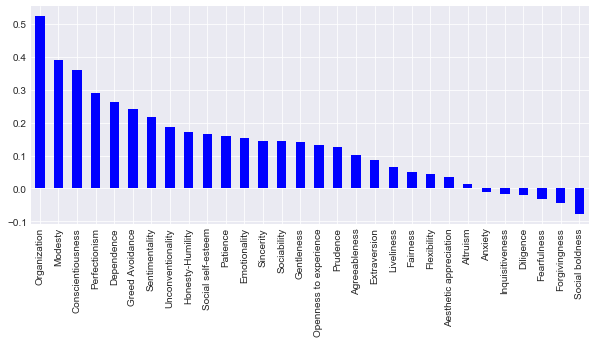

In [95]:
vocab_df.select_dtypes(include=[np.number]).corrwith(vocab_df['vocabulary'])\
.sort_values(ascending=False)[1:].plot.bar(figsize=(10,4), color='blue')

Not at all what I expected, but this is an imperfect way of measuring vocabulary. When I have a bit more time, I'll limit it to the first few hundred words so we're always comparing apples to apples. As people write more, they'll inevitably start repeating themselves.

For now though, people who are conscientious (organized, responsible, and detail-oriented) score the highest on vocabulary measures. People who keep to themselves and generally don't like other people 